In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

In [2]:
# import red wine csv
reds = pd.read_csv("winequality-red.csv", delimiter=';')

# import white wine csv
whites = pd.read_csv("winequality-white.csv", delimiter=';')

In [3]:
display(reds['quality'].value_counts())
display(whites['quality'].value_counts())

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [4]:
# the outcome classes are very unbalanced. To remedy it slightly, we will combine some classes.
# for the logistic regression, we want 5 classes:
#     combine '3' and '4' in both reds and whites
#     in whites, combine '8' and '9'. there are no 9 reds, so it will stay unbalanced.

# for the SVC, we want 3 classes:
#     combine 3-5 in both reds and whites
#     in whites, combine 7-9
#     in reds, combine 7-8

# we do all replacements here into different columns
# additionally, we encode each classs here
# we do this in two different steps to avoid a potential misreplacement, e.g. of 8 -> 4 -> 0


# whites dataframe
# combine to 5 classes for logit
whites['quality5classes'] = whites['quality'].replace(to_replace=[3, 4, 8, 9], value=['3-4', '3-4', '8-9', '8-9']).astype(str)
# encode
whites['quality5encoded'] = whites['quality5classes'].replace(to_replace=['3-4', '5', '6', '7', '8-9'],
                                                             value=[0, 1, 2, 3, 4])
# combine to 3 classes for svm
whites['quality3classes'] = whites['quality'].replace(to_replace=[3, 4, 5, 7, 8, 9],
                                                      value=['3-5', '3-5', '3-5', '7-9', '7-9', '7-9']).astype(str)
# encode
whites['quality3encoded'] = whites['quality3classes'].replace(to_replace=['3-5', '6', '7-9'],
                                                             value=[0, 1, 2])


# reds dataframe
# combine to 5 classes for logit
reds['quality5classes'] = reds['quality'].replace(to_replace=[3, 4], value=['3-4', '3-4']).astype(str)
# enconde
reds['quality5encoded'] = reds['quality5classes'].replace(to_replace=['3-4', '5', '6', '7', '8'],
                                                         value=[0, 1, 2, 3, 4])

# combine to 3 classes for svm
reds['quality3classes'] = reds['quality'].replace(to_replace=[3, 4, 5, 7, 8],
                                                 value=['3-5', '3-5', '3-5', '7-8', '7-8']).astype(str)
# encode
reds['quality3encoded'] = reds['quality3classes'].replace(to_replace=['3-5', '6', '7-8'],
                                                         value=[0, 1, 2])

In [5]:
# the updated value counts
print("reds 5 classes:\n", reds['quality5classes'].value_counts())
print("reds 3 classes:\n", reds['quality3classes'].value_counts())
print("whites 5 classes:\n", whites['quality5classes'].value_counts())
print("whites 3 classes:\n", whites['quality3classes'].value_counts())

reds 5 classes:
 5      681
6      638
7      199
3-4     63
8       18
Name: quality5classes, dtype: int64
reds 3 classes:
 3-5    744
6      638
7-8    217
Name: quality3classes, dtype: int64
whites 5 classes:
 6      2198
5      1457
7       880
3-4     183
8-9     180
Name: quality5classes, dtype: int64
whites 3 classes:
 6      2198
3-5    1640
7-9    1060
Name: quality3classes, dtype: int64


In [6]:
# split features and targets

# whites dataframe
# features are all but the quality columns
Xwhites_unscaled = whites.drop(columns=['quality', 'quality5classes', 'quality3classes', 'quality5encoded', 'quality3encoded']).values
# targets for Logit is quality5encoded column
ywhitesLogit = whites['quality5encoded'].values
# targets for SVM is quality3encoded column
ywhitesSVM = whites['quality3encoded'].values


# reds dataframe
Xreds_unscaled = reds.drop(columns=['quality', 'quality5classes', 'quality3classes', 'quality5encoded', 'quality3encoded']).values
# targets for Logit is quality5encoded column
yredsLogit = reds['quality5encoded'].values
# targets for SVM is quality3encoded column
yredsSVM = reds['quality3encoded'].values

In [7]:
# split into training and testing data
# split for logit and split for svm separately
# default 75%-25%
# stratify the target columns so we don't end up with all '8-9' in the testing data, for example
# tr stands for training, tes stands for testing

# whites data
# logit
XwhitesLogit_tr_unscaled, XwhitesLogit_tes_unscaled, ywhitesLogit_tr, ywhitesLogit_tes = \
                train_test_split(Xwhites_unscaled, ywhitesLogit, stratify=ywhitesLogit, random_state=23)
# svm
XwhitesSVM_tr_unscaled, XwhitesSVM_tes_unscaled, ywhitesSVM_tr, ywhitesSVM_tes = \
                train_test_split(Xwhites_unscaled, ywhitesSVM, stratify=ywhitesSVM, random_state=23)

# reds data
# logit
XredsLogit_tr_unscaled, XredsLogit_tes_unscaled, yredsLogit_tr, yredsLogit_tes = \
                train_test_split(Xreds_unscaled, yredsLogit, stratify=yredsLogit, random_state=23)
# svm
XredsSVM_tr_unscaled, XredsSVM_tes_unscaled, yredsSVM_tr, yredsSVM_tes = \
                train_test_split(Xreds_unscaled, yredsSVM, stratify=yredsSVM, random_state=23)

In [8]:
# scale the data with standard scaler
# separate scaler for logits and svms for red and white


# whites data
# instantiate scalers
whitesLogitScaler = StandardScaler()
whitesSVMScaler = StandardScaler()

# fit and transform training data
XwhitesLogit_tr_scaled = whitesLogitScaler.fit_transform(XwhitesLogit_tr_unscaled)
XwhitesSVM_tr_scaled = whitesSVMScaler.fit_transform(XwhitesSVM_tr_unscaled)

# transform testing data
XwhitesLogit_tes_scaled = whitesLogitScaler.transform(XwhitesLogit_tes_unscaled)
XwhitesSVM_tes_scaled = whitesSVMScaler.transform(XwhitesSVM_tes_unscaled)


#reds data
# instantiate scalers
redsLogitScaler = StandardScaler()
redsSVMScaler = StandardScaler()

# fit and transform training data
XredsLogit_tr_scaled = redsLogitScaler.fit_transform(XredsLogit_tr_unscaled)
XredsSVM_tr_scaled = redsSVMScaler.fit_transform(XredsSVM_tr_unscaled)

# transform testing data
XredsLogit_tes_scaled = redsLogitScaler.transform(XredsLogit_tes_unscaled)
XredsSVM_tes_scaled = redsSVMScaler.transform(XredsSVM_tes_unscaled)

In [9]:
# logistic regression on whites

# use random_state=23
# multi_class = 'multinomial' for multiple target classes
# solver='lbfgs' (default anyway)

# instantiate model
whitesLogit = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=23)

# fit the logit model to training data
whitesLogit.fit(XwhitesLogit_tr_scaled, ywhitesLogit_tr)

# make predictions. compare to ywhitesLogit_tes
ywhitesLogit_Preds = whitesLogit.predict(XwhitesLogit_tes_scaled)

In [10]:
# logistic regression on whites
# raw accuracy scores
print("whites Logit training data raw accuracy: ", whitesLogit.score(XwhitesLogit_tr_scaled, ywhitesLogit_tr))
print("whites Logit testing data raw accuracy: ", whitesLogit.score(XwhitesLogit_tes_scaled, ywhitesLogit_tes))

whites Logit training data raw accuracy:  0.5505036754696433
whites Logit testing data raw accuracy:  0.5306122448979592


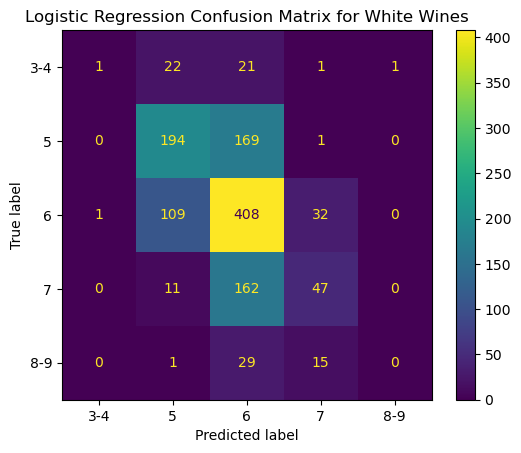

In [11]:
# logistic regression on whites
# confusion matrix plot
dis=ConfusionMatrixDisplay(confusion_matrix(ywhitesLogit_tes, ywhitesLogit_Preds), display_labels=['3-4', '5', '6', '7', '8-9'])
dis.plot()
plt.title("Logistic Regression Confusion Matrix for White Wines")
plt.savefig("static/images/logit_whites_confusion_matrix.png", bbox_inches='tight')
plt.show()

In [12]:
# logistic regression on reds

# use random_state=23
# multi_class = 'multinomial' for multiple target classes
# solver='lbfgs' (default anyway)

# instantiate model
redsLogit = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=23)

# fit the logit model to training data
redsLogit.fit(XredsLogit_tr_scaled, yredsLogit_tr)

# make predictions. compare to ywhitesLogit_tes
yredsLogit_Preds = redsLogit.predict(XredsLogit_tes_scaled)

In [13]:
# logistic regression on reds
# raw accuracy scores
print("reds Logit training data raw accuracy: ", redsLogit.score(XredsLogit_tr_scaled, yredsLogit_tr))
print("reds Logit testing data raw accuracy: ", redsLogit.score(XredsLogit_tes_scaled, yredsLogit_tes))

reds Logit training data raw accuracy:  0.6113427856547122
reds Logit testing data raw accuracy:  0.565


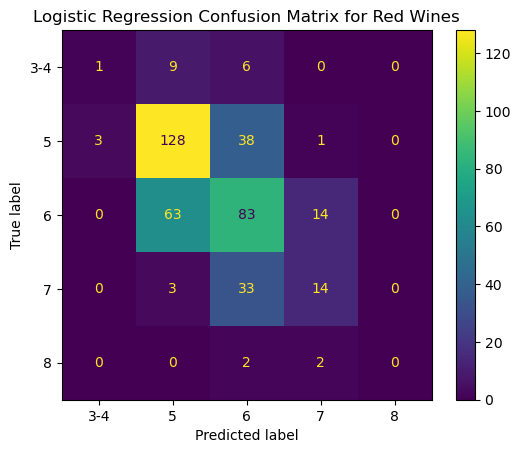

In [14]:
# logistic regression on reds
# confusion matrix plot
dis=ConfusionMatrixDisplay(confusion_matrix(yredsLogit_tes, yredsLogit_Preds), display_labels=['3-4', '5', '6', '7', '8'])
dis.plot()
plt.title("Logistic Regression Confusion Matrix for Red Wines")
plt.savefig("static/images/logit_reds_confusion_matrix.png", bbox_inches='tight')
plt.show()

In [15]:
# support vector machine on whites

# use random_state=23
# decision_function_shape="ovo" (already does ovo under the hood for multiclass, but enforce it)
# kernel ='rbf' (default anyway)
# C=1.0 (default)

# instantiate model
whitesSVC = SVC(decision_function_shape='ovo', random_state=23)

# fit the SVC model to training data
whitesSVC.fit(XwhitesSVM_tr_scaled, ywhitesSVM_tr)

# make predictions. compare to ywhitesSVM_tes
ywhitesSVM_Preds = whitesSVC.predict(XwhitesSVM_tes_scaled)

In [16]:
# SVM on whites
# raw accuracy scores
print("whites SVM training data raw accuracy: ", whitesSVC.score(XwhitesSVM_tr_scaled, ywhitesSVM_tr))
print("whites SVM testing data raw accuracy: ", whitesSVC.score(XwhitesSVM_tes_scaled, ywhitesSVM_tes))

whites SVM training data raw accuracy:  0.662945820854887
whites SVM testing data raw accuracy:  0.6244897959183674


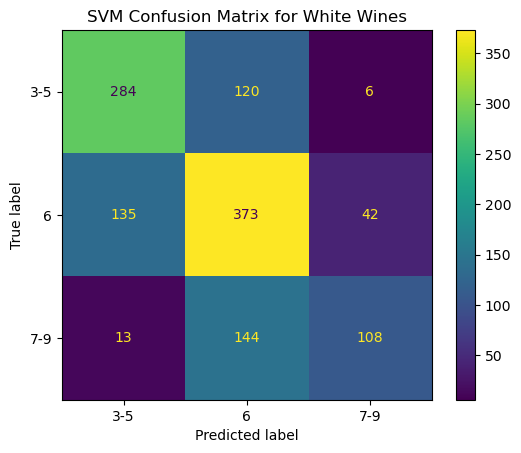

In [17]:
# SVM on whites
# confusion matrix plot
dis=ConfusionMatrixDisplay(confusion_matrix(ywhitesSVM_tes, ywhitesSVM_Preds), display_labels=['3-5','6', '7-9'])
dis.plot()
plt.title("SVM Confusion Matrix for White Wines")
plt.savefig("static/images/svm_whites_confusion_matrix.png", bbox_inches='tight')
plt.show()

In [18]:
# support vector machine on reds

# use random_state=23
# decision_function_shape="ovo" (already does ovo under the hood for multiclass, but enforce it)
# kernel ='rbf' (default anyway)
# C=1.0 (default)

# instantiate model
redsSVC = SVC(decision_function_shape='ovo', random_state=23)

# fit the SVC model to training data
redsSVC.fit(XredsSVM_tr_scaled, yredsSVM_tr)

# make predictions. compare to ywhitesSVM_tes
yredsSVM_Preds = redsSVC.predict(XredsSVM_tes_scaled)

In [19]:
# SVM on reds
# raw accuracy scores
print("reds SVM training data raw accuracy: ", redsSVC.score(XredsSVM_tr_scaled, yredsSVM_tr))
print("reds SVM testing data raw accuracy: ", redsSVC.score(XredsSVM_tes_scaled, yredsSVM_tes))

reds SVM training data raw accuracy:  0.7139282735613011
reds SVM testing data raw accuracy:  0.6175


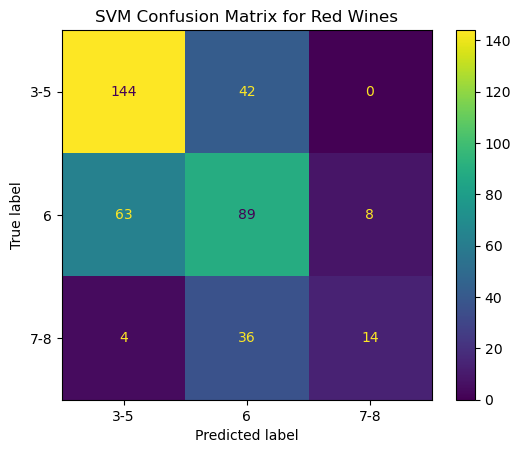

In [20]:
# SVM on reds
# confusion matrix plot
dis=ConfusionMatrixDisplay(confusion_matrix(yredsSVM_tes, yredsSVM_Preds), display_labels=['3-5','6', '7-8'])
dis.plot()
plt.title("SVM Confusion Matrix for Red Wines")
plt.savefig("static/images/svm_reds_confusion_matrix.png", bbox_inches='tight')
plt.show()